# MQ-2 

## Burned Paper

### Specifications

#### Standard Work Condition

    Vc (Circuit Voltage)       :  5v +/- 0.1
    Vh (Heating Voltage)       :  5v +/- 0.1
    Rl (Load Resistance)       :  can adjust
    Rh (Heater Resistance)     :  33 ohm +/- 5%
    Ph (Heating consumption)   :  less than 800mw
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 3kOhm  -  30kOhm (1000ppm iso-butane)
    Preheat Time               : Over 24 hour
    
    Detecting Concentration Scope:
        LPG and Propane:  200ppm  - 5000ppm 
        Butane:           300ppm  - 5000ppm  
        Methane:          5000ppm - 20000ppm 
        H2:               300ppm  - 5000ppm 
        Alcohol:          100ppm  - 2000ppm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet

POINTS = {
    # Hydrogen
    'h2' : { 
        'p1': {'x': 200,   'y': 2.063},
        'p2': {'x': 500,   'y': 1.346},
        'p3': {'x': 800,   'y': 1.090},
        'p4': {'x': 1000,  'y': 1.000},
        'p5': {'x': 1500,  'y': 0.820},
        'p6': {'x': 2000,  'y': 0.716},
        'p7': {'x': 3000,  'y': 0.580},
        'p8': {'x': 5000,  'y': 0.458},
        'p9': {'x': 10000, 'y': 0.328}
    },  
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1': {'x': 200,   'y': 1.589},
        'p2': {'x': 500,   'y': 1.044},
        'p3': {'x': 800,   'y': 0.867},
        'p4': {'x': 1000,  'y': 0.771},
        'p5': {'x': 1500,  'y': 0.648},
        'p6': {'x': 2000,  'y': 0.562},
        'p7': {'x': 3000,  'y': 0.461},
        'p8': {'x': 5000,  'y': 0.358},
        'p9': {'x': 10000, 'y': 0.256}
    },
    # Methane
    'ch4' : {
        'p1': {'x': 200,   'y': 3.028},
        'p2': {'x': 500,   'y': 2.236},
        'p3': {'x': 800,   'y': 1.880},
        'p4': {'x': 1000,  'y': 1.746},
        'p5': {'x': 1500,  'y': 1.505},
        'p6': {'x': 2000,  'y': 1.346},
        'p7': {'x': 3000,  'y': 1.139},
        'p8': {'x': 5000,  'y': 0.928},
        'p9': {'x': 10000, 'y': 0.694}
    },
    # Carbon Monoxide
    'co' : {
        'p1': {'x': 200,   'y': 5.125},
        'p2': {'x': 500,   'y': 3.903},
        'p3': {'x': 800,   'y': 3.343},
        'p4': {'x': 1000,  'y': 3.104},
        'p5': {'x': 1500,  'y': 2.709},
        'p6': {'x': 2000,  'y': 2.484},
        'p7': {'x': 3000,  'y': 2.154},
        'p8': {'x': 5000,  'y': 1.789},
        'p9': {'x': 10000, 'y': 1.388}
    },  
    'alcohol' : {
        'p1': {'x': 200,   'y': 2.829},
        'p2': {'x': 500,   'y': 2.025},
        'p3': {'x': 800,   'y': 1.713},
        'p4': {'x': 1000,  'y': 1.581},
        'p5': {'x': 1500,  'y': 1.380},
        'p6': {'x': 2000,  'y': 1.242},
        'p7': {'x': 3000,  'y': 1.084},
        'p8': {'x': 5000,  'y': 0.873},
        'p9': {'x': 10000, 'y': 0.644}
    },
    'smoke' : {
        'p1': {'x': 200,   'y': 3.364},
        'p2': {'x': 500,   'y': 2.364},
        'p3': {'x': 800,   'y': 1.963},
        'p4': {'x': 1000,  'y': 1.823},
        'p5': {'x': 1500,  'y': 1.591},
        'p6': {'x': 2000,  'y': 1.414},
        'p7': {'x': 3000,  'y': 1.167},
        'p8': {'x': 5000,  'y': 0.923},
        'p9': {'x': 10000, 'y': 0.602}
    },
    #  C3H8
    'propane' : {
        'p1': {'x': 200,   'y': 1.682},
        'p2': {'x': 500,   'y': 1.084},
        'p3': {'x': 800,   'y': 0.889},
        'p4': {'x': 1000,  'y': 0.815},
        'p5': {'x': 1500,  'y': 0.677},
        'p6': {'x': 2000,  'y': 0.591},
        'p7': {'x': 3000,  'y': 0.491},
        'p8': {'x': 5000,  'y': 0.385},
        'p9': {'x': 10000, 'y': 0.276}
    }
}

AIR = 9.83

GASES = ['h2', 'lpg', 'ch4', 'co', 'alcohol', 'smoke', 'propane']

In [3]:
# RS value calculation
Rs = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0 = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
M = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
B = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM = lambda  racio, m, b: 10 ** ((math.log10(racio) - b) / m)

In [4]:
## Calculate the points to be used for the calculation 
## of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
df = pd.read_csv('burnedpaper_mq2.csv')

mq2_1 = pd.DataFrame({'volt': df["sensor1"]})
mq2_2 = pd.DataFrame({'volt': df["sensor2"]})
mq2_3 = pd.DataFrame({'volt': df["sensor3"]})
mq2_4 = pd.DataFrame({'volt': df["sensor4"]})
mq2_5 = pd.DataFrame({'volt': df["sensor5"]})
mq2_6 = pd.DataFrame({'volt': df["sensor6"]})


### Ro values to be considered

- __Sensor 1__: 27.21  kOhms
- __Sensor 2__: 7.68   kOhms
- __Sensor 3__: 454.55 kOhms !? inop
- __Sensor 4__: 3.77   kOhms
- __Sensor 5__: 37.93  kOhms
- __Sensor 6__: 21.43  kOhms


In [7]:
# MQ 2 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR  
sensor1['Ro']  = 27.21  #kOhms

# MQ 2 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 7.68   #kOhms

# MQ 2 - sensor 3
sensor3 = {}
sensor3['Vcc'] = 5      #volts
sensor3['RL']  = 10     #kOhms
sensor3['AIR'] = AIR   
sensor3['Ro']  = 454.55 #kOhms

# MQ 2 - sensor 4
sensor4 = {}
sensor4['Vcc'] = 5      #volts
sensor4['RL']  = 10     #kOhms
sensor4['AIR'] = AIR   
sensor4['Ro']  = 3.77   #kOhms

# MQ 2 - sensor 5
sensor5 = {}
sensor5['Vcc'] = 5      #volts
sensor5['RL']  = 10     #kOhms
sensor5['AIR'] = AIR   
sensor5['Ro']  = 37.93  #kOhms

# MQ 2 - sensor 6
sensor6 = {}
sensor6['Vcc'] = 5      #volts
sensor6['RL']  = 10     #kOhms
sensor6['AIR'] = AIR   
sensor6['Ro']  = 21.43   #kOhms

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_1['volt'].min(),
    mq2_1['volt'].mean(), 
    mq2_1['volt'].quantile(0.25),
    mq2_1['volt'].quantile(0.5),
    mq2_1['volt'].quantile(0.75),
    mq2_1['volt'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_2['volt'].min(),
    mq2_2['volt'].mean(), 
    mq2_2['volt'].quantile(0.25),
    mq2_2['volt'].quantile(0.5),
    mq2_2['volt'].quantile(0.75),
    mq2_2['volt'].max()]


sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_3['volt'].mean() if mq2_3['volt'].min() == 0 else mq2_3['volt'].min(),
    mq2_3['volt'].mean(), 
    mq2_3['volt'].quantile(0.25),
    mq2_3['volt'].quantile(0.5),
    mq2_3['volt'].quantile(0.75),
    mq2_3['volt'].max()]


sensor3['Rs'] = [Rs(sensor3['Vcc'] , v, sensor3['RL'] ) for v in Vrl]
sensor3['Ratio'] = [Ratio(rs, sensor3['Ro']) for rs in sensor3['Rs']]

ppm3 = {}
for gas in GASES:
    ppm3[gas] = []

for r in sensor3['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm3[gas].append(PPM(r, m, b))

In [11]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_4['volt'].min(),
    mq2_4['volt'].mean(), 
    mq2_4['volt'].quantile(0.25),
    mq2_4['volt'].quantile(0.5),
    mq2_4['volt'].quantile(0.75),
    mq2_4['volt'].max()]


sensor4['Rs'] = [Rs(sensor4['Vcc'] , v, sensor4['RL'] ) for v in Vrl]
sensor4['Ratio'] = [Ratio(rs, sensor4['Ro']) for rs in sensor4['Rs']]

ppm4 = {}
for gas in GASES:
    ppm4[gas] = []

for r in sensor4['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm4[gas].append(PPM(r, m, b))

In [12]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_5['volt'].min(),
    mq2_5['volt'].mean(), 
    mq2_5['volt'].quantile(0.25),
    mq2_5['volt'].quantile(0.5),
    mq2_5['volt'].quantile(0.75),
    mq2_5['volt'].max()]


sensor5['Rs'] = [Rs(sensor5['Vcc'] , v, sensor5['RL'] ) for v in Vrl]
sensor5['Ratio'] = [Ratio(rs, sensor5['Ro']) for rs in sensor5['Rs']]

ppm5 = {}
for gas in GASES:
    ppm5[gas] = []

for r in sensor5['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm5[gas].append(PPM(r, m, b))

In [13]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_6['volt'].min(),
    mq2_6['volt'].mean(), 
    mq2_6['volt'].quantile(0.25),
    mq2_6['volt'].quantile(0.5),
    mq2_6['volt'].quantile(0.75),
    mq2_6['volt'].max()]


sensor6['Rs'] = [Rs(sensor6['Vcc'] , v, sensor6['RL'] ) for v in Vrl]
sensor6['Ratio'] = [Ratio(rs, sensor6['Ro']) for rs in sensor6['Rs']]

ppm6 = {}
for gas in GASES:
    ppm6[gas] = []

for r in sensor6['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm6[gas].append(PPM(r, m, b))

In [14]:
def printMM3QM(name, sensor, ppm):
    print(name)

    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format('Rs/Ro', 
                   round(sensor['Ratio'][0],3),
                   round(sensor['Ratio'][1],3),
                   round(sensor['Ratio'][2],3),
                   round(sensor['Ratio'][3],3),
                   round(sensor['Ratio'][4],3),
                   round(sensor['Ratio'][5],3)))

    for gas in GASES:
        print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
               .format(gas.upper(), 
                       round(ppm[gas][0],3),
                       round(ppm[gas][1],3),
                       round(ppm[gas][2],3),
                       round(ppm[gas][3],3),
                       round(ppm[gas][4],3),
                       round(ppm[gas][5],3)))

In [15]:
printMM3QM("Sensor1", sensor1, ppm1)

print("-"*(12*7))

printMM3QM("Sensor2", sensor2, ppm2)

print("-"*(12*7))

printMM3QM("Sensor3", sensor3, ppm3)

print("-"*(12*7))

printMM3QM("Sensor4", sensor4, ppm4)

print("-"*(12*7))

printMM3QM("Sensor5", sensor5, ppm5)

print("-"*(12*7))
    
printMM3QM("Sensor5", sensor6, ppm6)

Sensor1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        11.883       9.387        11.117       9.841        8.383        6.983       
H2           4.67         7.746        5.388        6.999        9.874        14.615      
LPG          2.483        4.152        2.871        3.746        5.315        7.918       
CH4          3.212        6.549        3.928        5.677        9.218        16.013      
CO           11.815       26.115       14.782       22.276       38.21        70.656      
ALCOHOL      3.917        7.474        4.701        6.566        10.19        16.815      
SMOKE        7.542        13.914       8.967        12.307       18.668       30.007      
PROPANE      3.389        5.542        3.894        5.022        7.017        10.272      
------------------------------------------------------------------------------------
Sensor2
             Min          Mean         1Q           2Q           3Q           Ma

In [16]:

font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

In [17]:
# Sensor 1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq2_1["volt"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq2_1[gas] = [ round(val, 3) for val in ppm1[gas]]

print(mq2_1.head())

   volt     h2    lpg    ch4      co  alcohol   smoke  propane
0  0.17  6.164  3.292  4.747  18.252    5.582  10.552    4.438
1  0.17  6.164  3.292  4.747  18.252    5.582  10.552    4.438
2  0.16  5.388  2.871  3.928  14.782    4.701   8.967    3.894
3  0.16  5.388  2.871  3.928  14.782    4.701   8.967    3.894
4  0.17  6.164  3.292  4.747  18.252    5.582  10.552    4.438


In [18]:
# Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq2_2["volt"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq2_2[gas] = [ round(val, 3) for val in ppm2[gas]]

print(mq2_2.head())

   volt      h2    lpg     ch4      co  alcohol   smoke  propane
0  0.78  14.341  7.767  15.591  68.589   16.413  29.327   10.085
1  0.77  13.879  7.512  14.888  65.155   15.740  28.187    9.769
2  0.78  14.341  7.767  15.591  68.589   16.413  29.327   10.085
3  0.77  13.879  7.512  14.888  65.155   15.740  28.187    9.769
4  0.77  13.879  7.512  14.888  65.155   15.740  28.187    9.769


In [19]:
# Sensor 3

sensor3['Rs'] = [Rs(sensor3['Vcc'] , (0.00001 if v == 0 else v), sensor3['RL'] ) for v in mq2_3["volt"]]
sensor3['Ratio'] = [Ratio(rs, sensor3['Ro']) for rs in sensor3['Rs']]

ppm3 = {}
for gas in GASES:
    ppm3[gas] = []
    
for r in sensor3['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm3[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq2_3[gas] = [ round(val, 3) for val in ppm3[gas]]

print(mq2_2.head())

   volt      h2    lpg     ch4      co  alcohol   smoke  propane
0  0.78  14.341  7.767  15.591  68.589   16.413  29.327   10.085
1  0.77  13.879  7.512  14.888  65.155   15.740  28.187    9.769
2  0.78  14.341  7.767  15.591  68.589   16.413  29.327   10.085
3  0.77  13.879  7.512  14.888  65.155   15.740  28.187    9.769
4  0.77  13.879  7.512  14.888  65.155   15.740  28.187    9.769


In [20]:
# Sensor 4

sensor4['Rs'] = [Rs(sensor4['Vcc'] , v, sensor4['RL'] ) for v in mq2_4["volt"]]
sensor4['Ratio'] = [Ratio(rs, sensor4['Ro']) for rs in sensor4['Rs']]

ppm4 = {}
for gas in GASES:
    ppm4[gas] = []
    
for r in sensor4['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm4[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq2_4[gas] = [ round(val, 3) for val in ppm4[gas]]

print(mq2_4.head())

   volt      h2     lpg     ch4       co  alcohol   smoke  propane
0  1.67  26.525  14.513  37.070  179.874   35.999  61.740   18.335
1  1.66  26.017  14.231  36.075  174.507   35.122  60.313   17.994
2  1.66  26.017  14.231  36.075  174.507   35.122  60.313   17.994
3  1.66  26.017  14.231  36.075  174.507   35.122  60.313   17.994
4  1.64  25.027  13.680  34.156  164.204   33.423  57.544   17.328


In [21]:
# Sensor 5

sensor5['Rs'] = [Rs(sensor5['Vcc'] , v, sensor5['RL'] ) for v in mq2_5["volt"]]
sensor5['Ratio'] = [Ratio(rs, sensor5['Ro']) for rs in sensor5['Rs']]

ppm5 = {}
for gas in GASES:
    ppm5[gas] = []
    
for r in sensor5['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm5[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq2_5[gas] = [ round(val, 3) for val in ppm5[gas]]

print(mq2_5.head())

   volt     h2    lpg    ch4      co  alcohol   smoke  propane
0  0.15  9.525  5.124  8.763  36.115    9.733  17.872    6.776
1  0.15  9.525  5.124  8.763  36.115    9.733  17.872    6.776
2  0.15  9.525  5.124  8.763  36.115    9.733  17.872    6.776
3  0.15  9.525  5.124  8.763  36.115    9.733  17.872    6.776
4  0.14  8.178  4.388  7.069  28.437    8.011  14.860    5.843


In [22]:
# Sensor 6

sensor6['Rs'] = [Rs(sensor6['Vcc'] , v, sensor6['RL'] ) for v in mq2_6["volt"]]
sensor6['Ratio'] = [Ratio(rs, sensor6['Ro']) for rs in sensor6['Rs']]

ppm6 = {}
for gas in GASES:
    ppm6[gas] = []
    
for r in sensor6['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm6[gas].append(PPM(r, m, b)) 

for gas in GASES:       
    mq2_6[gas] = [ round(val, 3) for val in ppm6[gas]]

print(mq2_6.head())

   volt      h2    lpg     ch4      co  alcohol   smoke  propane
0  0.27  10.421  5.614   9.945  41.580   10.917  19.927    7.394
1  0.28  11.318  6.106  11.172  47.327   12.131  22.021    8.012
2  0.27  10.421  5.614   9.945  41.580   10.917  19.927    7.394
3  0.27  10.421  5.614   9.945  41.580   10.917  19.927    7.394
4  0.27  10.421  5.614   9.945  41.580   10.917  19.927    7.394


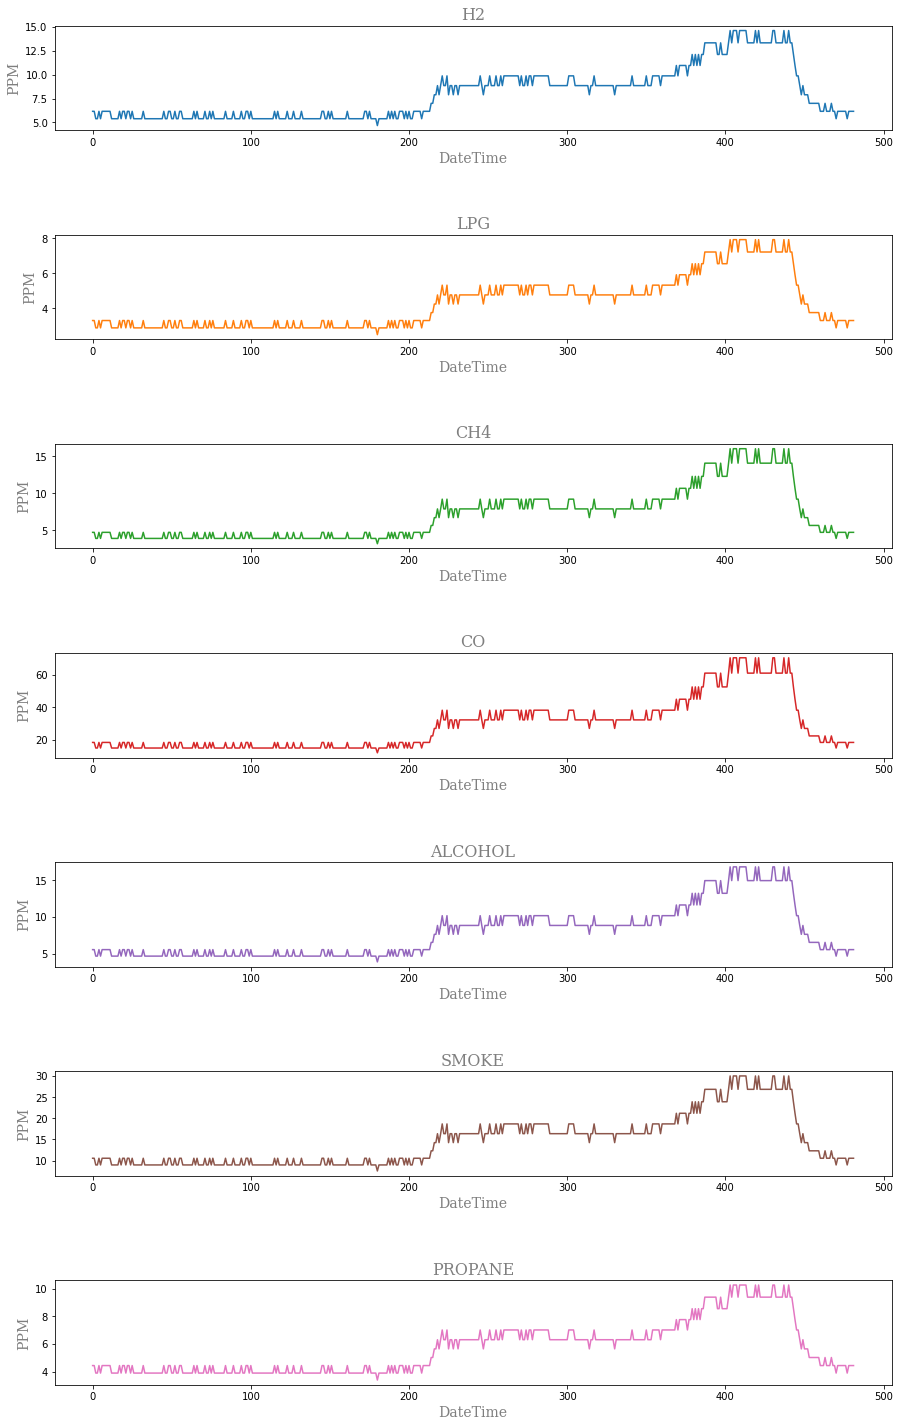

In [23]:
# Sensor 1
plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(mq2_1[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

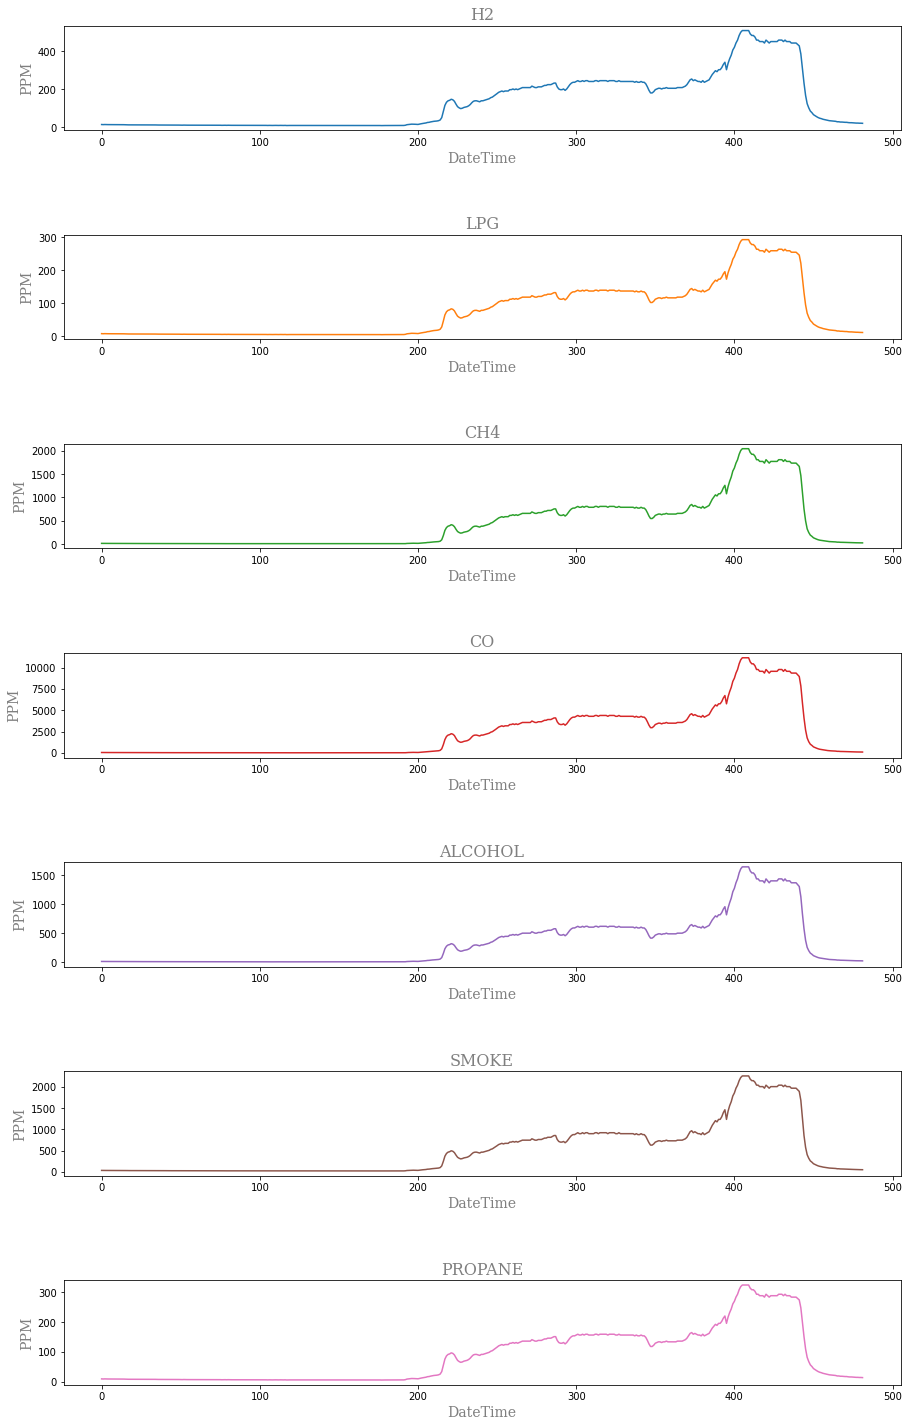

In [24]:
# Sensor 2

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(mq2_2[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

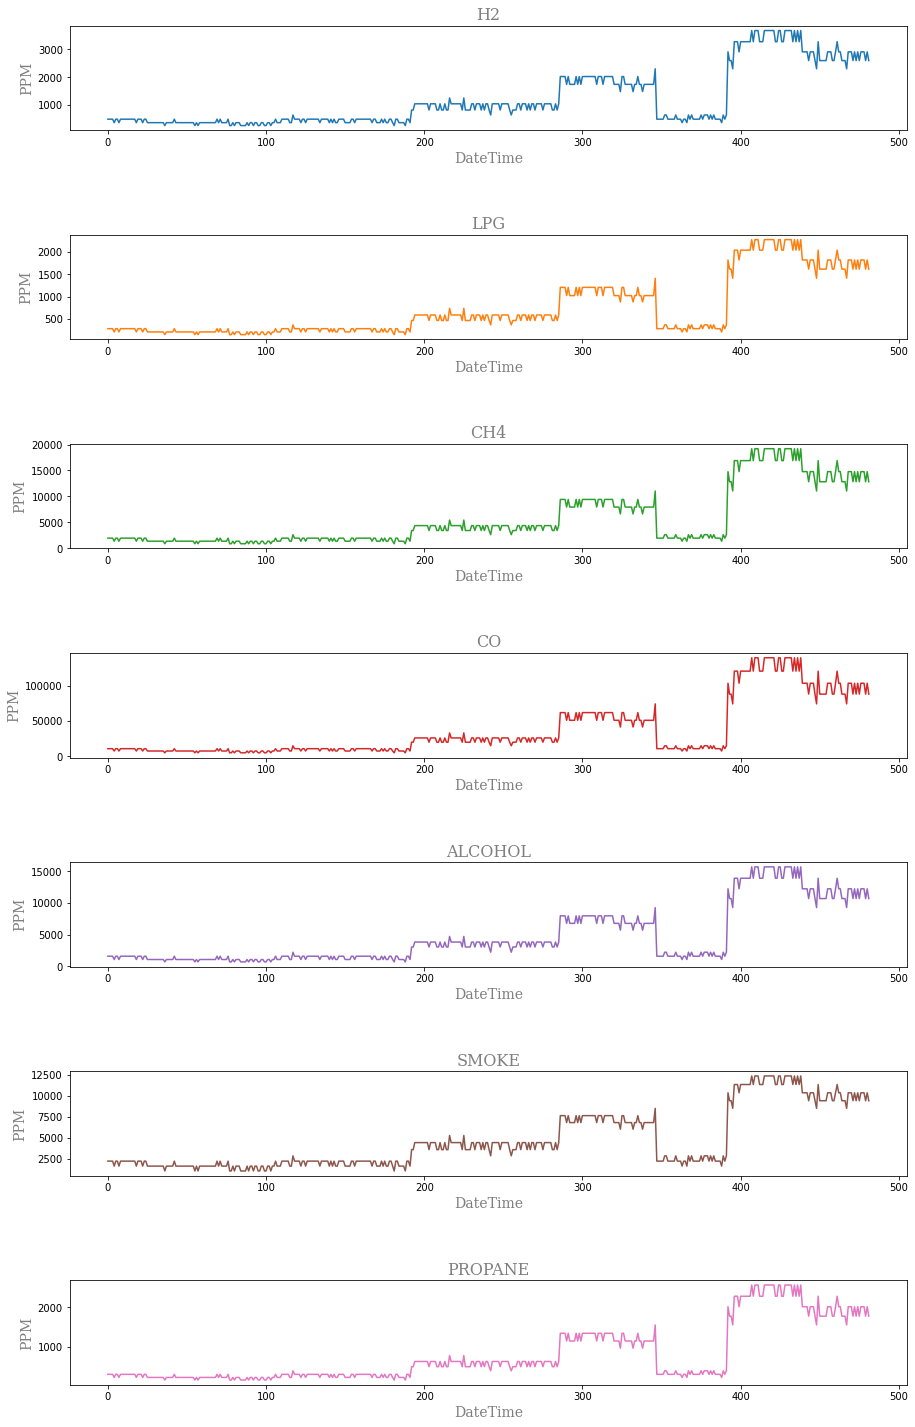

In [25]:
# Sensor 3

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(mq2_3[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

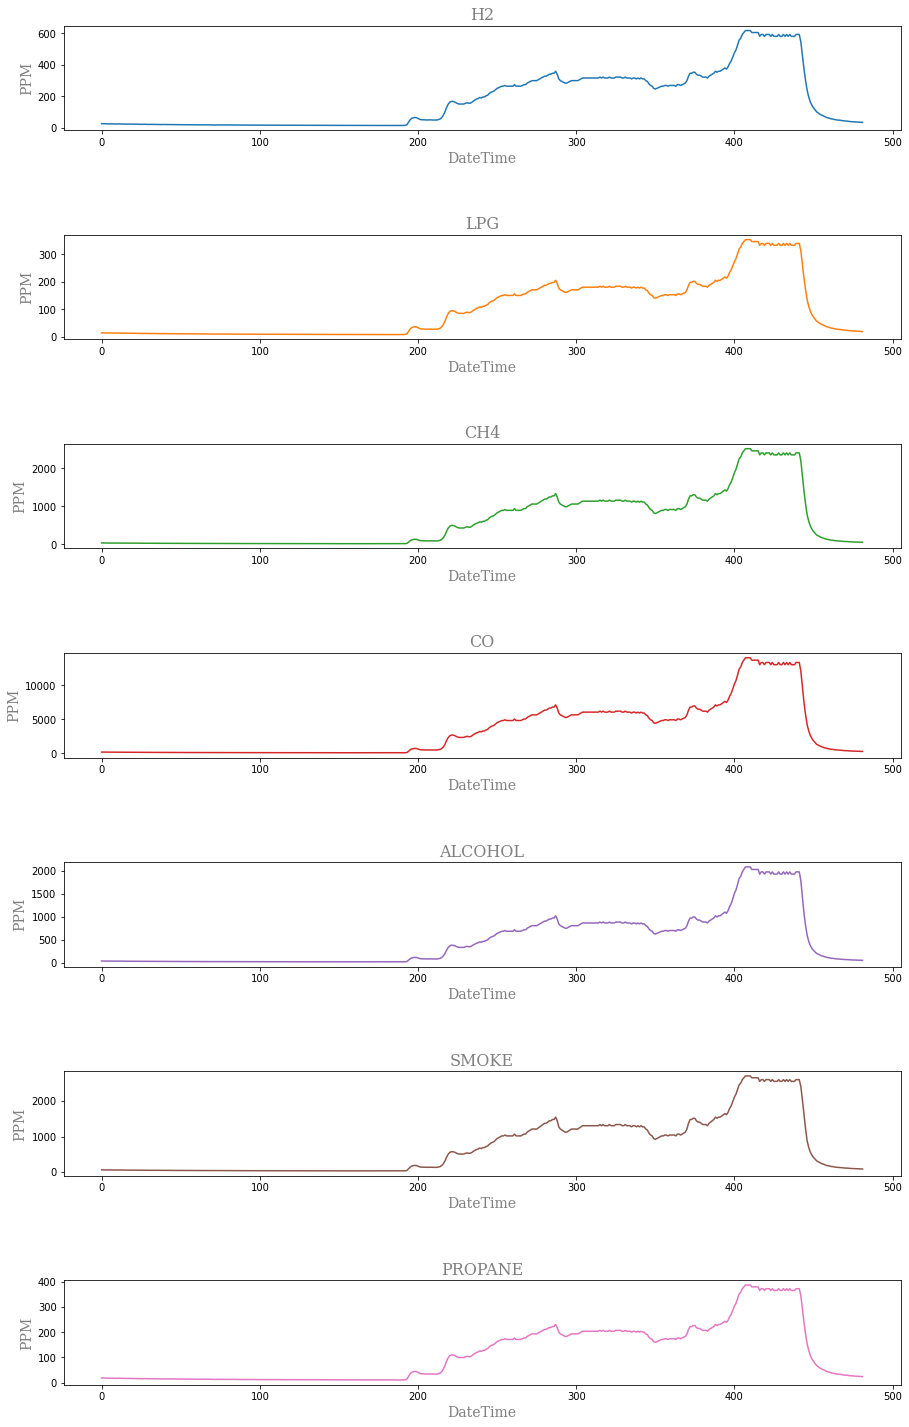

In [26]:
# Sensor 4

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(mq2_4[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

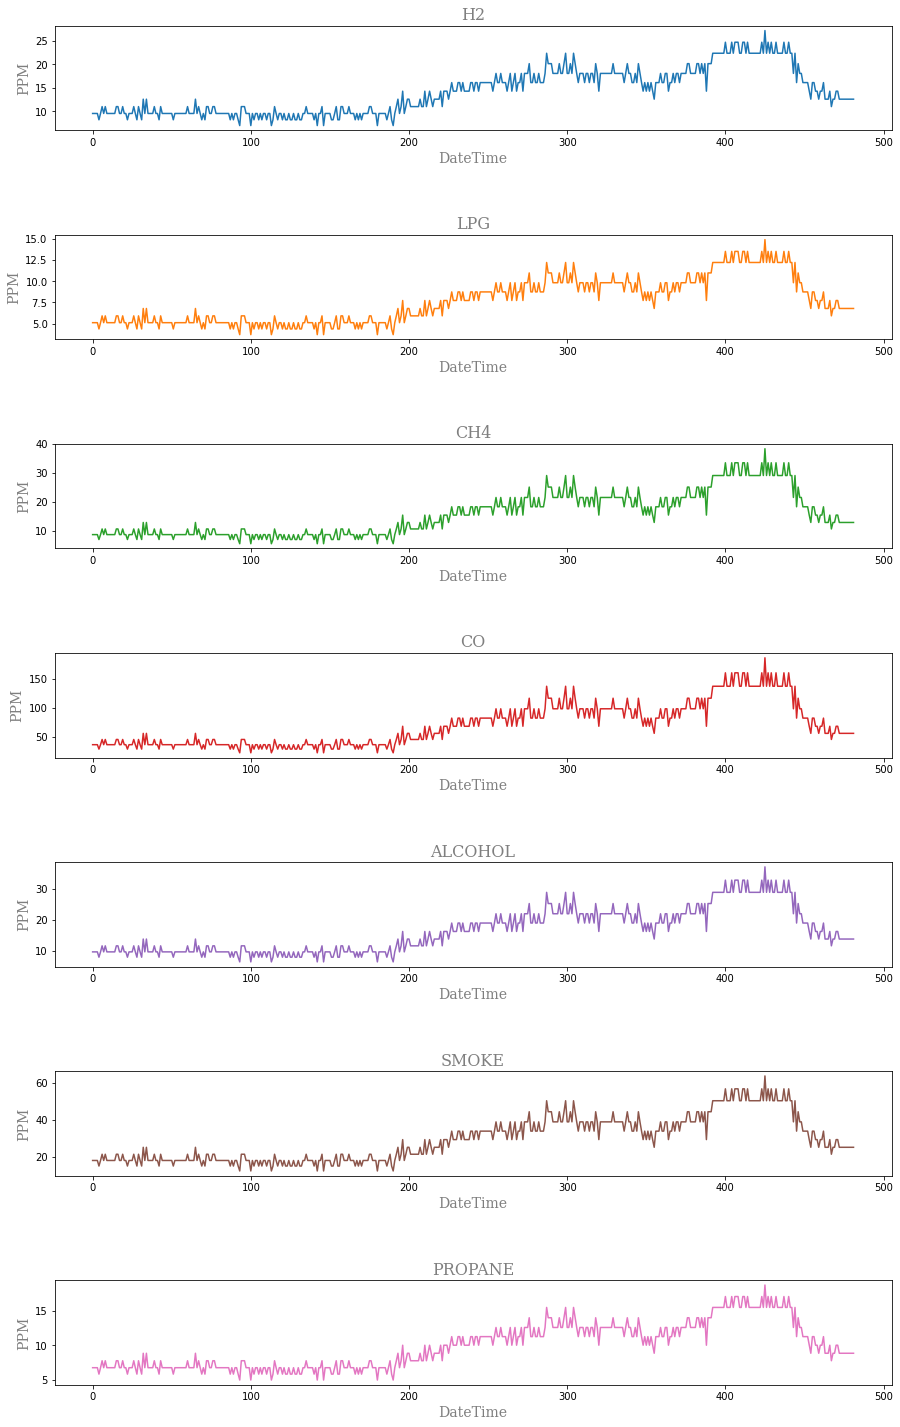

In [27]:
# Sensor 5

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(mq2_5[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

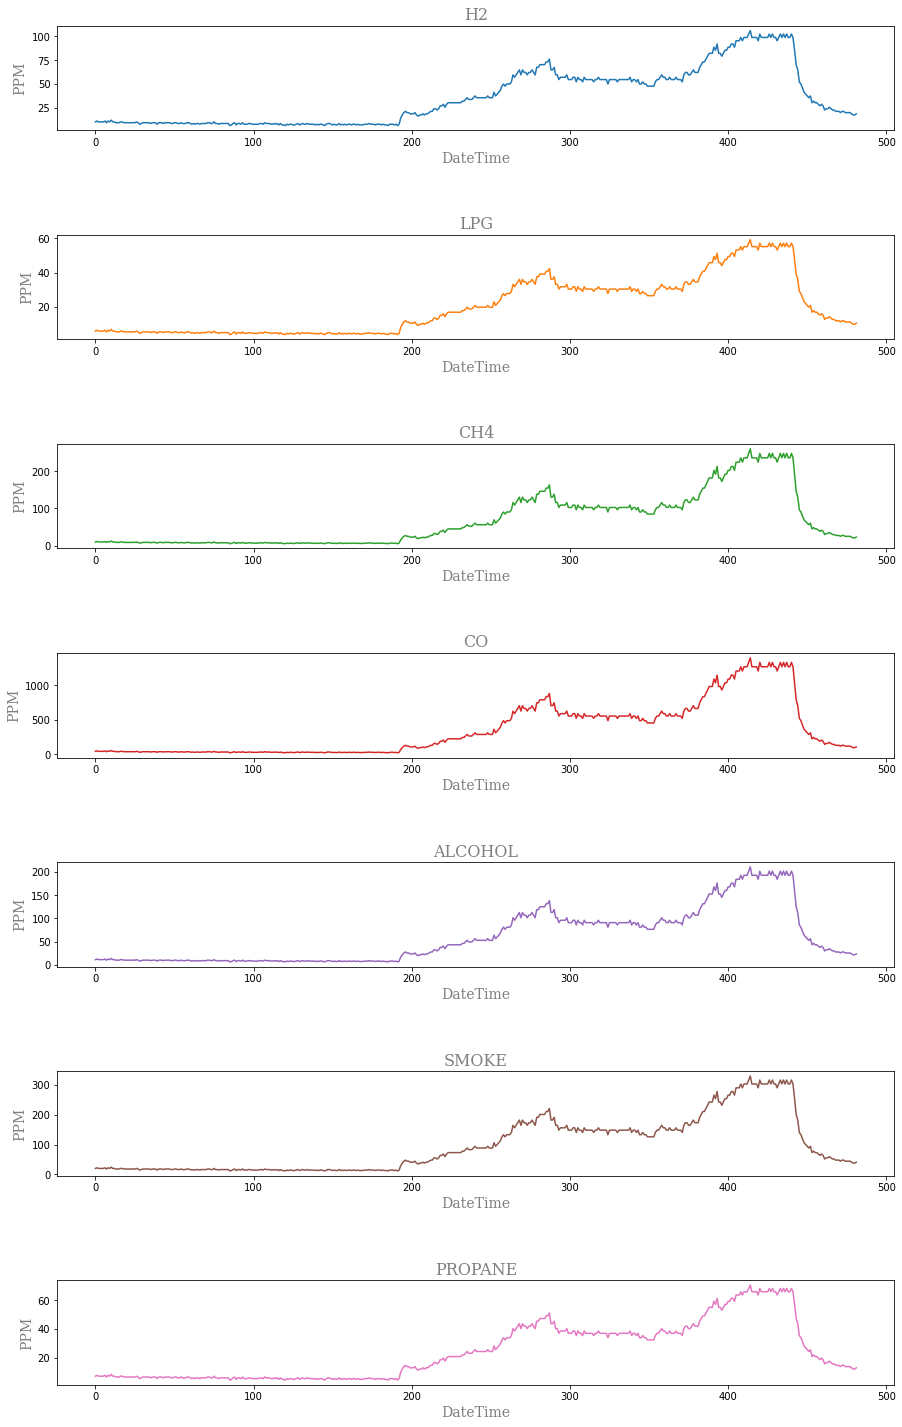

In [28]:
# Sensor 6

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(mq2_6[GASES[idx]],                            color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    
plt.show()

In [29]:
# Save in csv file
mq2_1.to_csv('mq2_1.csv')
mq2_2.to_csv('mq2_2.csv')
mq2_3.to_csv('mq2_3.csv')
mq2_4.to_csv('mq2_4.csv')
mq2_5.to_csv('mq2_5.csv')
mq2_6.to_csv('mq2_6.csv')